In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage2",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2536 files belonging to 4 classes.


In [8]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

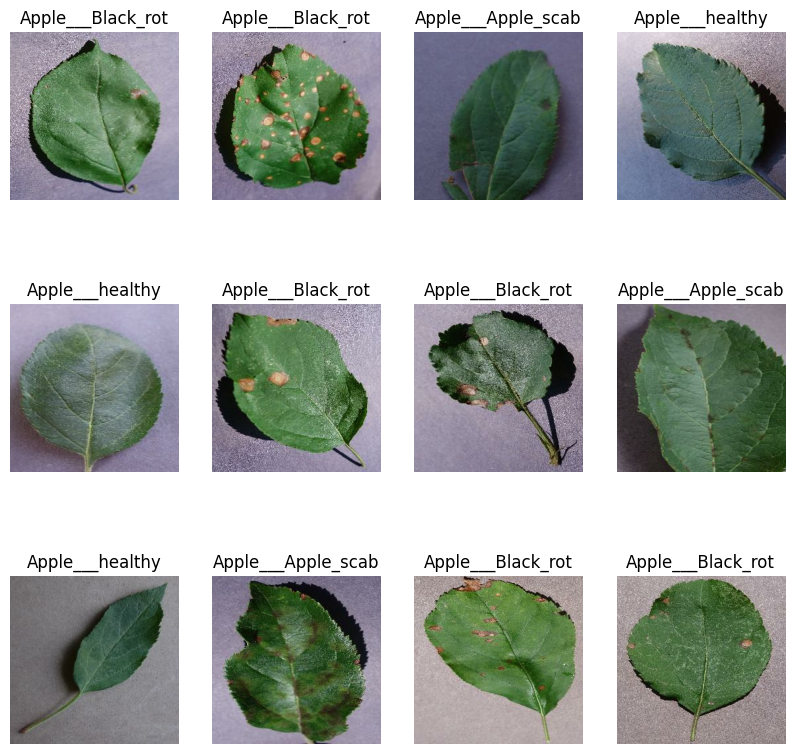

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
train_size = 0.8
len(dataset)*train_size

64.0

In [11]:
train_ds = dataset.take(64)
len(train_ds)

64

In [12]:
test_ds = dataset.skip(64)
len(test_ds)

16

In [13]:
val_size= 0.1
len(dataset)*val_size

8.0

In [14]:
val_ds = test_ds.take(8)
len(val_ds)


8

In [15]:
test_ds = test_ds.skip(8)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

64

In [19]:
len(val_ds)

8

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.AveragePooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.AveragePooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.AveragePooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.AveragePooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.AveragePooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 average_pooling2d (Average  (32, 127, 127, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (32, 62, 62, 64)          0         
 gePooling2D)                                         

In [26]:
model.compile(
    optimizer = 'RMSprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


64/64 [==============================] - 46s 652ms/step - loss: 1.2388 - accuracy: 0.5122 - val_loss: 1.0786 - val_accuracy: 0.5938
Epoch 2/50
64/64 [==============================] - 42s 652ms/step - loss: 1.0282 - accuracy: 0.5845 - val_loss: 0.8650 - val_accuracy: 0.6289
Epoch 3/50
64/64 [==============================] - 40s 623ms/step - loss: 0.8921 - accuracy: 0.6426 - val_loss: 0.7811 - val_accuracy: 0.6797
Epoch 4/50
64/64 [==============================] - 40s 631ms/step - loss: 0.7900 - accuracy: 0.6968 - val_loss: 0.6520 - val_accuracy: 0.7227
Epoch 5/50
64/64 [==============================] - 40s 620ms/step - loss: 0.7082 - accuracy: 0.7104 - val_loss: 0.5559 - val_accuracy: 0.8047
Epoch 6/50
64/64 [==============================] - 40s 621ms/step - loss: 0.6697 - accuracy: 0.7539 - val_loss: 0.7840 - val_accuracy: 0.6953
Epoch 7/50
64/64 [==============================] - 40s 629ms/step - loss: 0.6278 - accuracy: 0.7500 - val_loss: 0.5439 - val_accuracy: 0.78

In [28]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 9s 254ms/step - loss: 0.0122 - accuracy: 1.0000


first image to predict
first image's actual label: Apple___healthy
1/1 [==============================] - 0s 307ms/step
predicted label: Apple___Black_rot


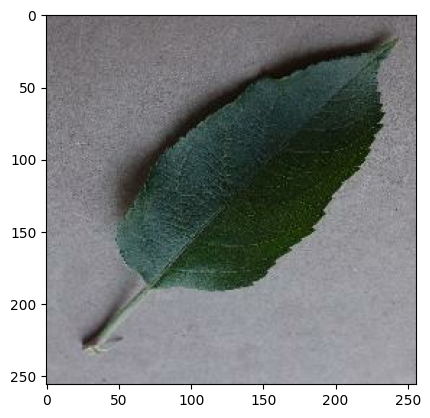

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 79ms/step


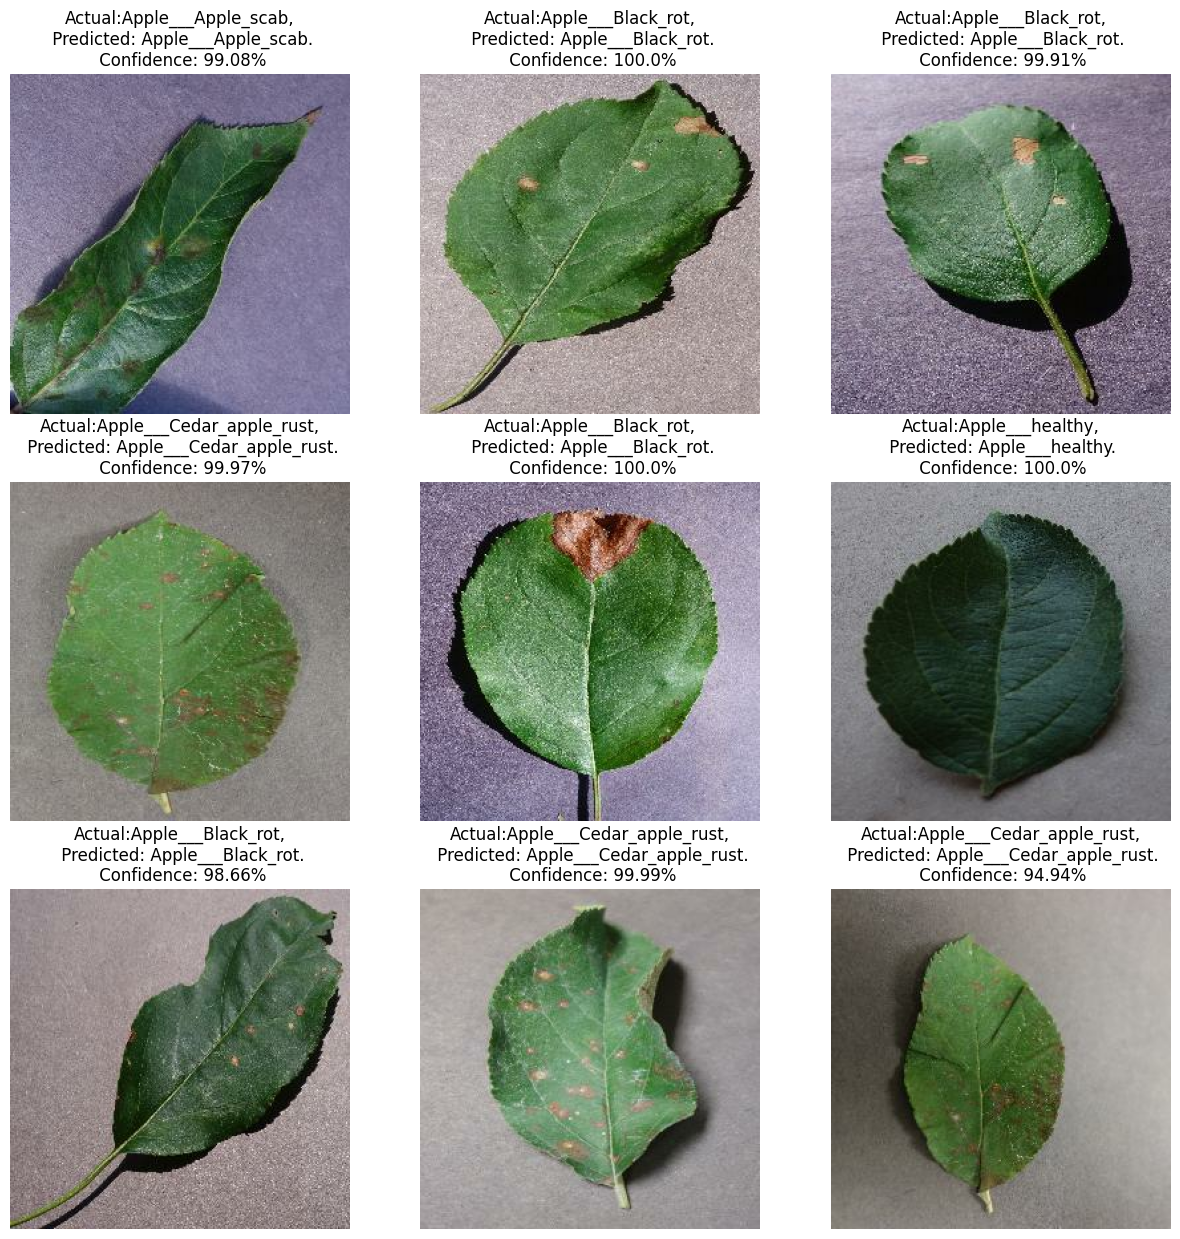

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")